In [127]:
import os
import pandas as pd
import numpy as np
import tweepy
import time
from tweepy import OAuthHandler
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup as bs
from urllib.parse import urljoin, urlparse
from requests_oauthlib import OAuth1
from newspaper import Article
from newspaper import Config
from transformers import pipeline
from newspaper import Config
from newspaper import Article
import traceback
import logging
import re
import urllib
from transformers import pipeline
from termcolor import colored
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [128]:
#Assigning API/Access Keys
consumer_key = '91OBPUpS2KtpZ5u6QmjdLd81D'
consumer_secret = '7zKK17hHjFMlfUT8NPrQFQArAxyhJYhH8m7fxrwbM5crGgMDDk'
access_token = '1484372306231128071-Buh0RShEK5lIKUI92gogVoucJhvUmp'
access_secret = '43YVRS7kLMzn2jUnzDdrCIZKYdhtkcJEmDn1wXnuio1vC'
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [130]:
user_name = input("Enter Username of twitter account you're interested in: ")

Enter Username of twitter account you're interested in: CNN


In [138]:

#Add the number of tweets you want to get
number_of_tweets= 10
#count: maximum allowed tweets count
#tweet_mode: extended to get the full text,it prevents a primary tweet longer than 140 characters from being truncated.
timeline = api.user_timeline(screen_name = user_name,count=number_of_tweets,tweet_mode="extended")
# Iterate and print tweets
tweet_text = [tweet.full_text for tweet in timeline]
tweet_ids = [tweet.id for tweet in timeline]
tweet_df = pd.DataFrame()
tweet_df['Tweet ID'] = tweet_ids
tweet_df['Text'] = tweet_text
#Storing tweet ids and text in a csv file for later use
tweet_df.to_csv('tweets.csv')


In [139]:
#Reading relevant tweet ids from csv file
tweets = pd.read_csv("tweets.csv")


In [140]:
#Function to extract article links from tweet texts
def get_article_links(tweets):
    article_links = []
    for tweet in tweets['Text'].to_numpy():
            urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', tweet)
            for i in range(len(urls)):
                res = urllib.request.urlopen(urls[i].strip())
                urls[i] = res.geturl()
                print("expanded url = " + urls[i])
                #Checking if the expanded url is an external link to an article, as opposed to a twitter link
                if("twitter.com" not in urls[i] and urls[i] not in article_links):
                    article_links.append(urls[i])
    return article_links
              
#Function to extract relevant information from news articles given links as inputs
def get_articles(article_links):
    articles = []
    for url in article_links:
        try:
            article = Article(url.strip())
            article.download() 
            article.parse()
            date = article.publish_date
            authors = ", ".join(author for author in article.authors)
            title = article.title
            #Formatting date
            if date is not None:
                date = date.strftime("%m/%d/%Y")
            else:
                date = ''
                
            text = article.text
            url = article.url
            articles.append(
            {
                'Author': authors,
                'Title': title,
                'Date': date,
                'Link': url,
                'Text': text
            }
            )
        except Exception as e:
            logging.error(traceback.format_exc())
    return articles


#Function that performs summarization to summarize article text, and sentiment analysis to get the sentiment of article title.
def summarization_and_sentiment(articles):
    summaries = []
    #Pretrained Model for Summarization
    model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
    tokenizer = AutoTokenizer.from_pretrained("t5-base")

    Title_Sentiments = []

    for index,article in articles.iterrows():
        # T5 uses max_length of 512
        inputs = tokenizer("summarize: " + articles['Text'].iloc[index], return_tensors="pt", max_length=512, truncation=True)
        outputs = model.generate(
            inputs["input_ids"], max_length=120, min_length=40, length_penalty=2.0, num_beams=2, early_stopping=True
        )
        summary = tokenizer.decode(outputs[0])
        #Removing unneccesary characters from summary
        summary = re.sub('<[^>]+>', '', summary).strip()
        
        summaries.append(summary)

        #Pretrained Model for Sentiment Analysis of Article Title
        sentiment_analyzer = SentimentIntensityAnalyzer()
        sentence = article['Title']
        score = sentiment_analyzer.polarity_scores(sentence)
        if score['compound'] >= 0.05 :
            Title_Sentiments.append('Positive')
        elif score['compound'] <= - 0.05 :
            Title_Sentiments.append('Negative')
        else:
            Title_Sentiments.append('Neutral')

    articles['Title Sentiment'] = Title_Sentiments
    articles['Summary'] = summaries
    return articles

# Function to plot word clouds from article content
def cloud_plot(word_cloud):
    # Set figure size
    plt.figure(figsize=(6, 4.5))
    # Display image
    plt.imshow(word_cloud)
    #Removing axis
    plt.axis("off");
    plt.show();

#Function to display information in the articles dataframe in an organized manner
def display_articles(articles):
    for index,article in articles.iterrows():
        print(colored(article['Title'].upper(), attrs=['bold']))
        print(colored("By: ", attrs=['bold']) + article['Author'])
        print(colored("Summary:\n", attrs=['bold']) + article['Summary'])
        print(colored("Date: ", attrs=['bold']) + article['Date'])
        print(articles['Link'].iloc[index])
        sentiment_color = 'blue'
        if(article["Title Sentiment"].lower() == 'positive'):
            sentiment_color = 'green'

        elif(article["Title Sentiment"].lower() == 'negative'):
            sentiment_color = 'red'

        print(colored("Title Sentiment: ", attrs=['bold']) +  colored(article["Title Sentiment"], sentiment_color , attrs=['bold']) + '\n')

        # Generate word cloud
        word_cloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(article['Summary'])
        # Plot
        cloud_plot(word_cloud)


In [141]:
article_links = get_article_links(tweets)

expanded url = https://www.cnn.com/2022/01/26/politics/supreme-court-confirmation-process/index.html?utm_source=twCNN&utm_term=link&utm_medium=social&utm_content=2022-01-26T21%3A00%3A12
expanded url = https://www.cnn.com/2022/01/25/entertainment/olivia-munn-asian-hate-zoom-bomb-cec/index.html?utm_source=twCNN&utm_medium=social&utm_term=link&utm_content=2022-01-26T21%3A00%3A04
expanded url = https://www.cnn.com/2022/01/25/entertainment/peter-dinklage-snow-white-and-the-seven-dwarfs-remake/index.html?utm_content=2022-01-26T20%3A45%3A29&utm_source=twCNN&utm_term=link&utm_medium=social
expanded url = https://www.cnn.com/2022/01/26/politics/white-house-reaction-breyer-retirement/index.html?utm_content=2022-01-26T20%3A35%3A04&utm_source=twCNN&utm_term=link&utm_medium=social
expanded url = https://www.cnn.com/2022/01/26/business/mcdonalds-fan-hacks-meals/index.html?utm_source=twCNN&utm_medium=social&utm_term=link&utm_content=2022-01-26T20%3A33%3A02
expanded url = https://www.cnn.com/2022/01/2

In [134]:
articles = get_articles(article_links)

articles = pd.DataFrame(articles)

In [135]:
articles

,Author,Title,Date,Link,Text
0,"Cheri Mossburg, Amir Vera",This Silicon Valley city just voted to institu...,01/26/2022,https://www.cnn.com/2022/01/26/us/san-jose-gun...,"(CNN) The San Jose, California, city council v..."
1,Brad Lendon,US Navy wants to get crashed stealth fighter b...,01/25/2022,https://www.cnn.com/2022/01/25/asia/us-f-35-cr...,"Seoul, South Korea (CNN) The United States Nav..."
2,,Meet the retired Army Colonel who created a 'b...,01/26/2022,https://www.cnn.com/videos/politics/2022/01/26...,The January 6th Committee recently subpoenaed ...
3,"Allison Chinchar, Monica Garrett, Cnn Meteorol...",Bomb cyclone could bring powerful nor'easter t...,01/25/2022,https://www.cnn.com/2022/01/25/weather/noreast...,(CNN) A rapidly intensifying storm known as a ...
4,"Jessie Yeung, Steven Jiang, David Culver, Jenn...",US Embassy in China asks State Department to l...,01/26/2022,https://www.cnn.com/2022/01/26/china/china-us-...,Beijing (CNN) The US diplomatic mission in Chi...
5,"Jordan Valinsky, Cnn Business",Wordle-spoiling bot taken down by Twitter,01/26/2022,https://www.cnn.com/2022/01/26/tech/wordle-ans...,New York (CNN Business) Twitter has suspended ...
6,"Annie Grayer, Oliver Darcy",Alex Jones met with 1/6 committee and says he ...,01/25/2022,https://www.cnn.com/2022/01/25/politics/alex-j...,(CNN) Right-wing conspiracy theorist Alex Jone...
7,Jack Bantock,Tom Brady: 'It's not always what I want. It's ...,01/25/2022,https://www.cnn.com/2022/01/25/sport/tom-brady...,(CNN) Tom Brady will not have his shot at an e...
8,"Cheri Mossburg, Amir Vera",This Silicon Valley city just voted to institu...,01/26/2022,https://www.cnn.com/2022/01/26/us/san-jose-gun...,"(CNN) The San Jose, California, city council v..."


In [136]:
articles = summarization_and_sentiment(articles)

THIS SILICON VALLEY CITY JUST VOTED TO INSTITUTE FIRST-IN-THE-NATION GUN OWNERSHIP REQUIREMENTS
By: Cheri Mossburg, Amir Vera
Summary:
the ordinance requires most gun owners to pay a fee and carry liability insurance. the insurance vote passed 10-1, while the fees vote passed 8-3. gun rights supporters have threatened to sue to block the measures.
Date: 01/26/2022
https://www.cnn.com/2022/01/26/us/san-jose-gun-law-wednesday/index.html?utm_medium=social&utm_term=link&utm_source=twCNN&utm_content=2022-01-26T19%3A15%3A06
Title Sentiment: Negative



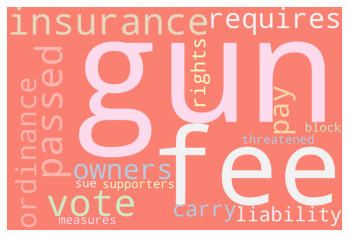

US NAVY WANTS TO GET CRASHED STEALTH FIGHTER BACK -- BEFORE CHINA CAN
By: Brad Lendon
Summary:
the single-engine stealth fighter crashed-landed on the aircraft carrier USS Carl Vinson. the $100 million warplane impacted the flight deck of the 100,000-ton aircraft carrier. it then fell into the sea as its pilot ejected, and six sailors aboard the Vinson were injured. analysts say the complex operation will be closely monitored by china.
Date: 01/25/2022
https://www.cnn.com/2022/01/25/asia/us-f-35-crash-recovery-south-china-sea-intl-hnk-ml/index.html?utm_content=2022-01-26T19%3A02%3A39&utm_medium=social&utm_term=link&utm_source=twCNN
Title Sentiment: Positive



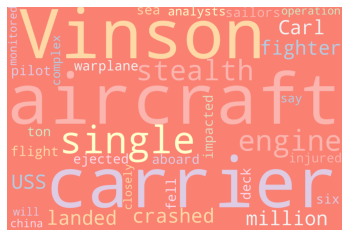

MEET THE RETIRED ARMY COLONEL WHO CREATED A 'BLUEPRINT' TO OVERTURN THE ELECTION
By: 
Summary:
the January 6th Committee recently subpoenaed Colonel Phil Waldren. they say he created a "blueprint" on overturning the 2020 election.
Date: 01/26/2022
https://www.cnn.com/videos/politics/2022/01/26/phil-waldren-blueprint-to-overturn-election-kaye-pkg-ac360-vpx.cnn
Title Sentiment: Positive



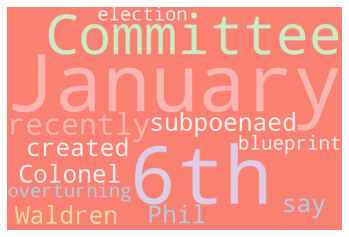

BOMB CYCLONE COULD BRING POWERFUL NOR'EASTER TO NORTHEAST CITIES THIS WEEKEND
By: Allison Chinchar, Monica Garrett, Cnn Meteorologists
Summary:
a bomb cyclone could bring crippling winter weather across the Northeast and Mid-Atlantic this weekend. snow, ice, strong winds and flooding are all on the table, giving rise to potentially hazardous travel conditions. the storm is expected to move up the east coast Friday into Saturday.
Date: 01/25/2022
https://www.cnn.com/2022/01/25/weather/noreaster-forecast-bomb-cyclone-weekend-storm/index.html?utm_term=link&utm_medium=social&utm_source=twCNN&utm_content=2022-01-26T18%3A47%3A21
Title Sentiment: Negative



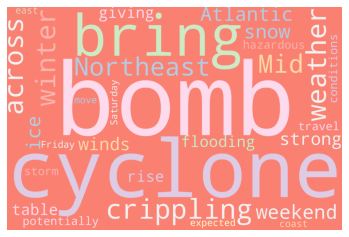

US EMBASSY IN CHINA ASKS STATE DEPARTMENT TO LET DIPLOMATS LEAVE OVER COVID RESTRICTIONS
By: Jessie Yeung, Steven Jiang, David Culver, Jennifer Hansler
Summary:
the request has not yet been approved by the State Department, sources say. an "authorized departure" gives employees and families the option to leave for a period of time. it is not a mandatory evacuation under an "ordered departure"
Date: 01/26/2022
https://www.cnn.com/2022/01/26/china/china-us-embassy-authorize-departure-intl-hnk/index.html?utm_content=2022-01-26T18%3A30%3A22&utm_term=link&utm_medium=social&utm_source=twCNN
Title Sentiment: Negative



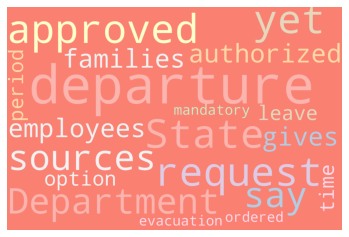

WORDLE-SPOILING BOT TAKEN DOWN BY TWITTER
By: Jordan Valinsky, Cnn Business
Summary:
@wordlinator would tweet: "To teach you a lesson, tomorrow's word is..." the bot was able to spoil future puzzles because the answers can be found in the game's source code. twitter removed the account on Tuesday.
Date: 01/26/2022
https://www.cnn.com/2022/01/26/tech/wordle-answer-bot-twitter/index.html?utm_content=2022-01-26T18%3A17%3A48&utm_medium=social&utm_term=link&utm_source=twCNN
Title Sentiment: Neutral



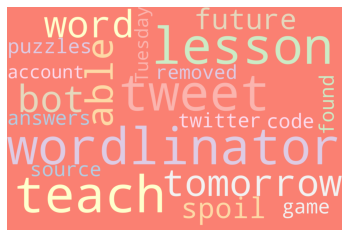

ALEX JONES MET WITH 1/6 COMMITTEE AND SAYS HE PLEADED THE FIFTH 'ALMOST 100 TIMES'
By: Annie Grayer, Oliver Darcy
Summary:
"they were polite, but they were dogged," the right-wing conspiracy theorist says. "the questions were overall pretty reasonable," he says. he says he was afraid of not answering all questions correctly.
Date: 01/25/2022
https://www.cnn.com/2022/01/25/politics/alex-jones-january-6-plead-fifth/index.html?utm_source=twCNN&utm_medium=social&utm_term=link&utm_content=2022-01-26T18%3A00%3A07
Title Sentiment: Neutral



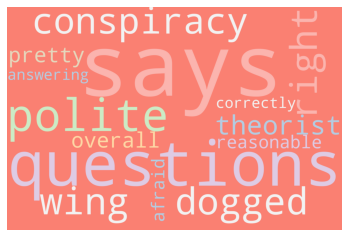

TOM BRADY: 'IT'S NOT ALWAYS WHAT I WANT. IT'S WHAT WE WANT AS A FAMILY.' WHAT NEXT FOR QUARTERBACK?
By: Jack Bantock
Summary:
quarterback says he hasn't put a lot of thought into retirement. despite heartbreaking end, Brady says his wife and kids will be at heart of any decision. he says he's gonna spend some time with them and give them what they need.
Date: 01/25/2022
https://www.cnn.com/2022/01/25/sport/tom-brady-future-family-buccaneers-nfl-spt-intl/index.html?utm_content=2022-01-26T17%3A43%3A01&utm_term=link&utm_medium=social&utm_source=twCNN
Title Sentiment: Positive



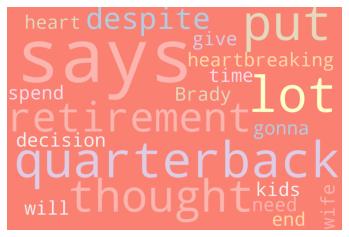

THIS SILICON VALLEY CITY JUST VOTED TO INSTITUTE FIRST-IN-THE-NATION GUN OWNERSHIP REQUIREMENTS
By: Cheri Mossburg, Amir Vera
Summary:
the ordinance requires most gun owners to pay a fee and carry liability insurance. the insurance vote passed 10-1, while the fees vote passed 8-3. gun rights supporters have threatened to sue to block the measures.
Date: 01/26/2022
https://www.cnn.com/2022/01/26/us/san-jose-gun-law-wednesday/index.html?utm_content=2022-01-26T17%3A26%3A27&utm_source=twCNN&utm_term=link&utm_medium=social
Title Sentiment: Negative



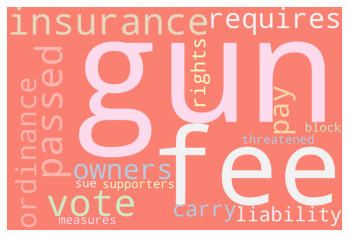

In [137]:
display_articles(pd.DataFrame(articles))
# If you particularly want to display maths, this is more direct:


None
